# Multi-class Modeling (Using Neural Networks)

In this notebook I am apply different machine learning models to predict the skills that I need from the job descriptions.

## Table of contents

1. [Dataset preparation](#Dataset-Preparation)
2. [Text preprocessing](#Text-Preprocessing)
3. [Word Embeddings](#Word-Embeddings)
    1. [Model Configuration](#Model-Configuration)
4. [Word2vec](#Word2vec)

## Dataset Preparation

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import io
import random
import pandas as pd                # Data processing

# Visualization imports
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

In [3]:
df = pd.read_csv('noun_chunks_classified.csv')
df['type'].value_counts()
df_skills     = df[df['type'] != "not_skill"]
df_not_skills = df[df['type'] == "not_skill"].sample(n=len(df[df['type'] == "hard_skill"]))
df = pd.concat([df_skills, df_not_skills], ignore_index=True)

In [4]:
test_ratio = 0.4

# Extract features and prediction vectors
X = df['chunks']
y = df['type'].map({'not_skill':0, 'hard_skill':1, 'soft_skill':2})

# Split into train, test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = test_ratio * 2, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)
    
X_train.shape, X_test.shape, X_val.shape
X.str.split().str.len().max()

18

In [5]:
# Prepare the training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(64)

# Prepare the testing dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(64)

As per tensorflow tutorial: https://www.tensorflow.org/text/guide/word_embeddings#configure_the_dataset_for_performance

`.cache()` Keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` Overlaps data preprocessing and model execution while training.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Let's understand how the tensorflow dataset is constructed:

In [7]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(label_batch[i].numpy(), text_batch.numpy()[i])

1 b'ML Ops best practices'
0 b'data science experience Experience'
0 b'Greece Deutsche Telekom Cloud Services EE'
1 b'statistics'
1 b'Coach and mentor fellow Data Engineers Required Skills Experience BSc MSc'


## Text Preprocessing

In [8]:
# Custom standardization function to strip remove uneccessary text and symbols.
def custom_standardization(input_data):
    input_df = tf.strings.lower(input_data)
    input_df = tf.strings.regex_replace(input_df, '(e.g.?)|(i.e.?).', '')
    input_df = tf.strings.regex_replace(input_df, '[^\u0020-\u007E]', '')
    input_df = tf.strings.regex_replace(input_df, '\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b', '')
    input_df = tf.strings.regex_replace(input_df, '(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '')
    input_df = tf.strings.regex_replace(input_df, '\B#([a-z0-9]{1,})', '')
    input_df = tf.strings.regex_replace(input_df, '[^\w\s+#]', ' ')
    
    return tf.strings.regex_replace(input_df, '(\s{2,})|(\n+)', '')

In [9]:
# Vocabulary size and number of words in a sequence.
vocab_size = 2500
sequence_length = 20

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(X_train)

In [10]:
vocabulary = vectorize_layer.get_vocabulary()
print('Vocabulary size: {}'.format(len(vocabulary)))

num = random.randint(1, len(vocabulary))
print(f"Word number {num} ---> ", vocabulary[num])

Vocabulary size: 449
Word number 410 --->  change


## Word Embeddings

Insert description

### Model Configuration

In [11]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 20, 16)            40000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 40,323
Trainable params: 40,323
Non-traina

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Callbacks

In [14]:
tf_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=15, verbose=1)
]

### Training

In [15]:
NUM_EPOCHS = 200

history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=tf_callbacks)

Epoch 1/200
4/4 [==============================] - 1s 150ms/step - loss: 1.0795 - accuracy: 0.4798 - val_loss: 1.0699 - val_accuracy: 0.4922
Epoch 2/200
4/4 [==============================] - 0s 40ms/step - loss: 1.0692 - accuracy: 0.4798 - val_loss: 1.0597 - val_accuracy: 0.4922
Epoch 3/200
4/4 [==============================] - 0s 34ms/step - loss: 1.0597 - accuracy: 0.4798 - val_loss: 1.0496 - val_accuracy: 0.4922
Epoch 4/200
4/4 [==============================] - 0s 31ms/step - loss: 1.0500 - accuracy: 0.4798 - val_loss: 1.0394 - val_accuracy: 0.4922
Epoch 5/200
4/4 [==============================] - 0s 32ms/step - loss: 1.0401 - accuracy: 0.4798 - val_loss: 1.0292 - val_accuracy: 0.4922
Epoch 6/200
4/4 [==============================] - 0s 32ms/step - loss: 1.0304 - accuracy: 0.4798 - val_loss: 1.0192 - val_accuracy: 0.4922
Epoch 7/200
4/4 [==============================] - 0s 34ms/step - loss: 1.0209 - accuracy: 0.4798 - val_loss: 1.0093 - val_accuracy: 0.4922
Epoch 8/200
4/4 [==

4/4 [==============================] - 0s 35ms/step - loss: 0.6512 - accuracy: 0.8565 - val_loss: 0.7680 - val_accuracy: 0.7159
Epoch 60/200
4/4 [==============================] - 0s 38ms/step - loss: 0.6411 - accuracy: 0.8610 - val_loss: 0.7638 - val_accuracy: 0.7226
Epoch 61/200
4/4 [==============================] - 0s 37ms/step - loss: 0.6310 - accuracy: 0.8610 - val_loss: 0.7597 - val_accuracy: 0.7271
Epoch 62/200
4/4 [==============================] - 0s 52ms/step - loss: 0.6207 - accuracy: 0.8610 - val_loss: 0.7556 - val_accuracy: 0.7315
Epoch 63/200
4/4 [==============================] - 0s 34ms/step - loss: 0.6104 - accuracy: 0.8610 - val_loss: 0.7514 - val_accuracy: 0.7315
Epoch 64/200
4/4 [==============================] - 0s 32ms/step - loss: 0.6001 - accuracy: 0.8700 - val_loss: 0.7473 - val_accuracy: 0.7293
Epoch 65/200
4/4 [==============================] - 0s 31ms/step - loss: 0.5898 - accuracy: 0.8700 - val_loss: 0.7432 - val_accuracy: 0.7315
Epoch 66/200
4/4 [========

4/4 [==============================] - 0s 29ms/step - loss: 0.2203 - accuracy: 0.9372 - val_loss: 0.6435 - val_accuracy: 0.7584
Epoch 118/200
4/4 [==============================] - 0s 29ms/step - loss: 0.2161 - accuracy: 0.9417 - val_loss: 0.6433 - val_accuracy: 0.7584
Epoch 119/200
4/4 [==============================] - 0s 32ms/step - loss: 0.2121 - accuracy: 0.9417 - val_loss: 0.6431 - val_accuracy: 0.7584
Epoch 120/200
4/4 [==============================] - 0s 29ms/step - loss: 0.2081 - accuracy: 0.9417 - val_loss: 0.6430 - val_accuracy: 0.7584
Epoch 121/200
4/4 [==============================] - 0s 32ms/step - loss: 0.2042 - accuracy: 0.9462 - val_loss: 0.6428 - val_accuracy: 0.7584
Epoch 122/200
4/4 [==============================] - 0s 46ms/step - loss: 0.2004 - accuracy: 0.9462 - val_loss: 0.6427 - val_accuracy: 0.7539
Epoch 123/200
4/4 [==============================] - 0s 40ms/step - loss: 0.1966 - accuracy: 0.9462 - val_loss: 0.6425 - val_accuracy: 0.7562
Epoch 124/200
4/4 [=

In [16]:
loss, accuracy = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}')

7/7 [==============================] - 0s 2ms/step - loss: 0.6349 - accuracy: 0.7589
Loss: 0.634922981262207, Accuracy: 0.7589285969734192


We see at this point that our naive model achieves an accuracy of 0.75 and a loss of 0.64. This model behaves kind of poor.

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

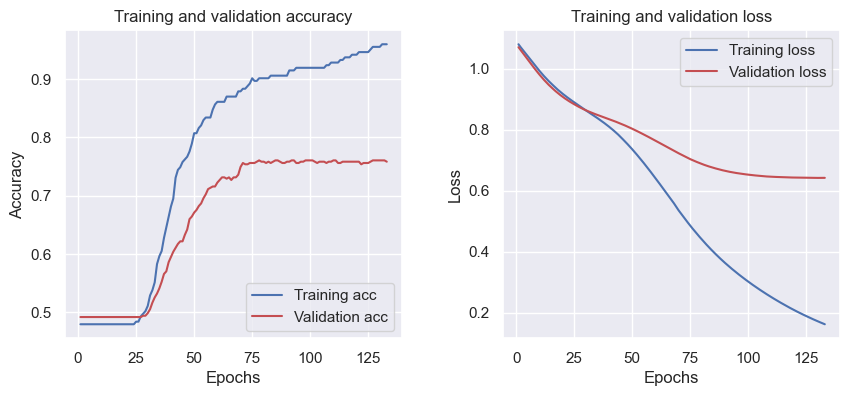

In [18]:
acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

axes[0].plot(epochs, acc, 'b', label='Training acc')
axes[0].plot(epochs, val_acc, 'r', label='Validation acc')

axes[0].set_title('Training and validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(epochs, loss, 'b', label='Training loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation loss')

axes[1].set_title('Training and validation loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()